In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
df = pd.read_csv("event_level_financial_metrics_with_CAR.csv")

In [3]:
df.head()

,fiscalDateEnding,reportedDate,reportedEPS,estimatedEPS,surprise,surprisePercentage,reportTime,symbol,totalRevenue,grossProfit,...,eps_surprise_regime,profitability_regime,margin_trend_regime,financial_strength_regime,event_id_reported,event_id_y,CAR_m1_p1,CAR_m2_p2,CAR_m5_p5,eps_bin2
0,2005-09-30,2005-10-11,0.01,0.01,0.0,0.0,post-market,AAPL,3678000000,1035000000,...,small,medium,missing,mixed,AAPL_2005-10-11,AAPL_2005-10-11,0.012122,0.092776,0.058988,0
1,2005-12-31,2006-01-18,0.02,0.02,0.0,0.0,post-market,AAPL,5749000000,1564000000,...,small,medium,contraction,mixed,AAPL_2006-01-18,AAPL_2006-01-18,-0.084419,-0.088700,-0.063810,0
2,2006-03-31,2006-04-19,0.02,0.02,0.0,0.0,post-market,AAPL,4359000000,1297000000,...,small,medium,stable,mixed,AAPL_2006-04-19,AAPL_2006-04-19,0.014441,-0.000814,-0.011341,0
3,2006-06-30,2006-07-19,0.02,0.02,0.0,0.0,post-market,AAPL,4370000000,1325000000,...,small,medium,expansion,mixed,AAPL_2006-07-19,AAPL_2006-07-19,0.153833,0.208736,0.170023,0
4,2006-09-30,2006-10-18,0.02,0.02,0.0,0.0,post-market,AAPL,4370000000,1412000000,...,small,medium,expansion,mixed,AAPL_2006-10-18,AAPL_2006-10-18,0.053754,0.065184,0.065574,0


In [4]:
df = df.rename(columns={
    "eps_surprise_regime": "eps_surprise_category",
    "profitability_regime": "profitability_category",
    "margin_trend_regime": "margin_trend_category",
    "financial_strength_regime": "financial_strength_category"
})

In [5]:
df.head()

,fiscalDateEnding,reportedDate,reportedEPS,estimatedEPS,surprise,surprisePercentage,reportTime,symbol,totalRevenue,grossProfit,...,eps_surprise_category,profitability_category,margin_trend_category,financial_strength_category,event_id_reported,event_id_y,CAR_m1_p1,CAR_m2_p2,CAR_m5_p5,eps_bin2
0,2005-09-30,2005-10-11,0.01,0.01,0.0,0.0,post-market,AAPL,3678000000,1035000000,...,small,medium,missing,mixed,AAPL_2005-10-11,AAPL_2005-10-11,0.012122,0.092776,0.058988,0
1,2005-12-31,2006-01-18,0.02,0.02,0.0,0.0,post-market,AAPL,5749000000,1564000000,...,small,medium,contraction,mixed,AAPL_2006-01-18,AAPL_2006-01-18,-0.084419,-0.088700,-0.063810,0
2,2006-03-31,2006-04-19,0.02,0.02,0.0,0.0,post-market,AAPL,4359000000,1297000000,...,small,medium,stable,mixed,AAPL_2006-04-19,AAPL_2006-04-19,0.014441,-0.000814,-0.011341,0
3,2006-06-30,2006-07-19,0.02,0.02,0.0,0.0,post-market,AAPL,4370000000,1325000000,...,small,medium,expansion,mixed,AAPL_2006-07-19,AAPL_2006-07-19,0.153833,0.208736,0.170023,0
4,2006-09-30,2006-10-18,0.02,0.02,0.0,0.0,post-market,AAPL,4370000000,1412000000,...,small,medium,expansion,mixed,AAPL_2006-10-18,AAPL_2006-10-18,0.053754,0.065184,0.065574,0


In [6]:
# Ensure reportedDate is a proper datetime
df["reportedDate"] = pd.to_datetime(df["reportedDate"])

In [7]:
# Filter to the current "tightening" period (2022-2025)
df_current = df[
    (df["reportedDate"] >= "2022-01-01") &
    (df["reportedDate"] <= "2025-12-31")
].copy()

# Sanity check the filter
df_current["reportedDate"].dt.year.value_counts().sort_index()

reportedDate
2022    12
2023    12
2024    12
2025    12
Name: count, dtype: int64

In [20]:
# Select the CAR window.
car_col = "CAR_m5_p5"

# Select the EPS surprise category
eps_col = "eps_surprise_category"

# Drop missing EPS categories
df_eps = df_current.dropna(subset=[eps_col])

# Aggregate mean CAR by EPS category (for all firms)
summary_eps_all = (
    df_eps
    .groupby(eps_col)[car_col]
    .agg(
        mean_car="mean",
        n_events="size"
    )
    .reset_index()
)

# Compute overall baseline (all events, all firms)
baseline_all = df_eps[car_col].mean()

# Inspect the results
summary_eps_all.sort_values("mean_car")

,eps_surprise_category,mean_car,n_events
4,small,-0.015617,9
2,moderate_negative,-0.013619,3
0,large_negative,-0.009566,3
3,moderate_positive,-0.001188,23
1,large_positive,0.044081,10


In [23]:
# Create merged 3-category version
df_eps["eps_surprise_category_3"] = df_eps["eps_surprise_category"].map({
    "large_negative": "negative",
    "moderate_negative": "negative",
    "small": "neutral",
    "moderate_positive": "positive",
    "large_positive": "positive"
})

# Switch to the merged column
eps_col = "eps_surprise_category_3"
df_eps = df_eps.dropna(subset=[eps_col])

# Re-aggregate
summary_eps_all = (
    df_eps
    .groupby(eps_col)[car_col]
    .agg(mean_car="mean", n_events="size")
    .reset_index()
)

# Inspect (sorted)
summary_eps_all = summary_eps_all.sort_values("mean_car")
summary_eps_all

,eps_surprise_category_3,mean_car,n_events
1,neutral,-0.015617,9
0,negative,-0.011593,6
2,positive,0.012530,33


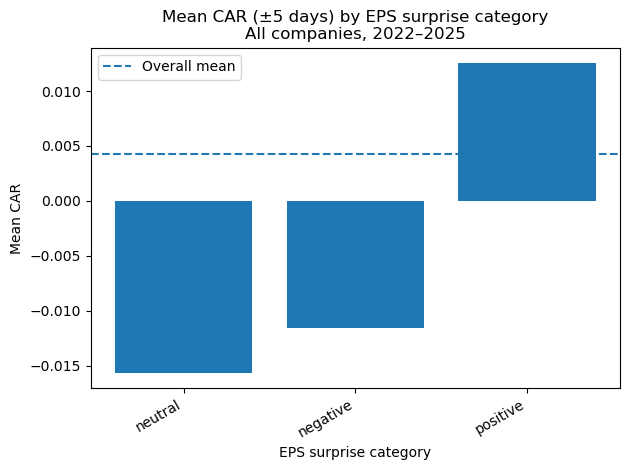

In [51]:
# Plot the chart
plt.figure()
plt.bar(
    summary_eps_all[eps_col].astype(str),
    summary_eps_all["mean_car"]
)
plt.axhline(
    baseline_all,
    linestyle="--",
    label="Overall mean"
)
plt.title("Mean CAR (±5 days) by EPS surprise category\nAll companies, 2022–2025")
plt.ylabel("Mean CAR")
plt.xlabel("EPS surprise category")

plt.xticks(rotation=30, ha="right")

plt.legend()
plt.tight_layout()
plt.savefig("eps.png", dpi=300, bbox_inches="tight")
plt.show()

In [12]:
# Merge EPS surprise categories to address sample size issue (more important later as we will create one chart per firm)
df_eps["eps_surprise_category_3"] = df_eps["eps_surprise_category"].map({
    "large_negative": "negative",
    "moderate_negative": "negative",
    "small": "neutral",
    "moderate_positive": "positive",
    "large_positive": "positive"
})

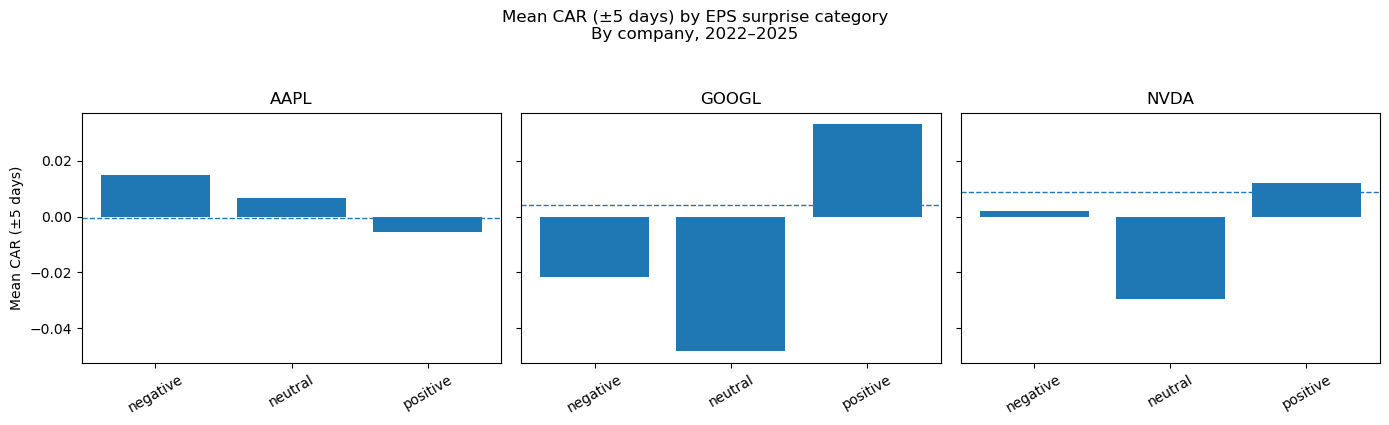

In [50]:
import matplotlib.pyplot as plt

tickers = sorted(df_eps["symbol"].unique())

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(tickers),
    figsize=(14, 4),
    sharey=True
)

for ax, ticker in zip(axes, tickers):
    df_t = df_eps[df_eps["symbol"] == ticker]

    summary = (
        df_t
        .groupby("eps_surprise_category_3")[car_col]
        .agg(mean_car="mean", n_events="size")
        .reset_index()
    )

    # enforce category order
    cat_order = ["negative", "neutral", "positive"]
    summary["eps_surprise_category_3"] = pd.Categorical(
        summary["eps_surprise_category_3"],
        categories=cat_order,
        ordered=True
    )
    summary = summary.sort_values("eps_surprise_category_3")

    baseline = df_t[car_col].mean()

    ax.bar(summary["eps_surprise_category_3"], summary["mean_car"])
    ax.axhline(baseline, linestyle="--", linewidth=1)

    ax.set_title(ticker)
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=30)

axes[0].set_ylabel("Mean CAR (±5 days)")
fig.suptitle(
    "Mean CAR (±5 days) by EPS surprise category\nBy company, 2022–2025",
    y=1.05
)

plt.tight_layout()
plt.savefig("eps_surprise_by_firm.png", dpi=300, bbox_inches="tight")
plt.show()

### Observations
For Apple, EPS surprises do not translate cleanly into short-term abnormal returns in the current regime.

EPS still matters for Google, but only on the upside.

For NVIDIA, only clearly positive earnings reinforce momentum; anything less is penalised.

In [41]:
# Set the metric to profitabilty
metric_col = "profitability_category"

# Drop missing profitability categories
df_prof = df_current.dropna(subset=[metric_col]).copy()

# Check the output.
df_prof[metric_col].value_counts()

profitability_category
high      41
medium     6
low        1
Name: count, dtype: int64

In [42]:
# Aggregate mean CAR by profitability
summary_prof_all = (
    df_prof
    .groupby(metric_col)[car_col]
    .agg(
        mean_car="mean",
        n_events="size"
    )
    .reset_index()
)

# Inspect results.
summary_prof_all.sort_values("mean_car")

,profitability_category,mean_car,n_events
1,low,-0.029378,1
0,high,0.003614,41
2,medium,0.014095,6


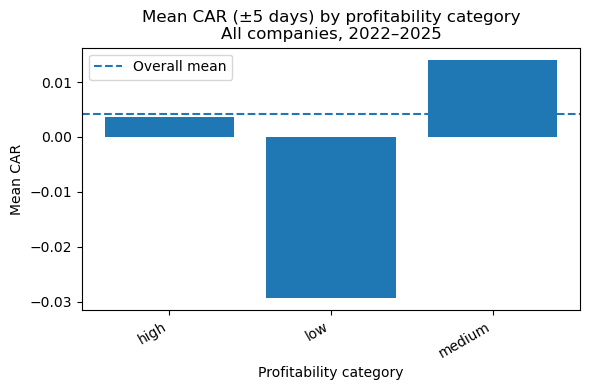

In [43]:
# Compute baseline
baseline_all = df_prof[car_col].mean()

# Plot the aggregate profitability chart
plt.figure(figsize=(6, 4))
plt.bar(
    summary_prof_all[metric_col].astype(str),
    summary_prof_all["mean_car"]
)
plt.axhline(
    baseline_all,
    linestyle="--",
    label="Overall mean"
)

plt.title(
    "Mean CAR (±5 days) by profitability category\nAll companies, 2022–2025"
)
plt.ylabel("Mean CAR")
plt.xlabel("Profitability category")
plt.xticks(rotation=30, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

### Observations
At an aggregate level, profitability does not show a simple “higher is better” relationship with short-term post-earnings returns, likely because highly profitable firms already have strong expectations priced in. The stronger reactions seen for medium-profitability firms suggest that earnings updates for these companies lead to larger revisions in investor expectations, while low-profitability firms are generally penalised.

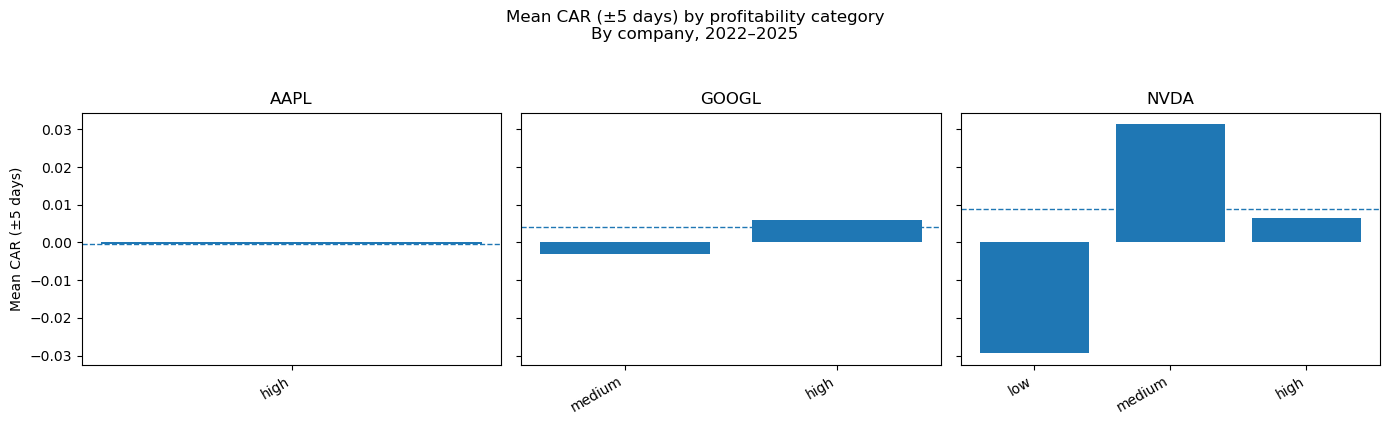

In [49]:
# Plot mean CAR by profitability by company

tickers = sorted(df_prof["symbol"].unique())
cat_order = ["low", "medium", "high"]

fig, axes = plt.subplots(1, len(tickers), figsize=(14, 4), sharey=True)

# Ensure axes is iterable
if len(tickers) == 1:
    axes = [axes]

for ax, ticker in zip(axes, tickers):
    df_t = df_prof[df_prof["symbol"] == ticker]

    summary = (
        df_t
        .groupby("profitability_category")[car_col]
        .agg(mean_car="mean", n_events="size")
        .reset_index()
    )

    # enforce category order
    summary["profitability_category"] = pd.Categorical(
        summary["profitability_category"],
        categories=cat_order,
        ordered=True
    )
    summary = summary.sort_values("profitability_category")

    x = range(len(summary))
    baseline = df_t[car_col].mean()

    bars = ax.bar(x, summary["mean_car"])
    ax.axhline(baseline, linestyle="--", linewidth=1)

    ax.set_xticks(x)
    ax.set_xticklabels(summary["profitability_category"], rotation=30, ha="right")
    ax.set_title(ticker)

    axes[0].set_ylabel("Mean CAR (±5 days)")

fig.suptitle(
    "Mean CAR (±5 days) by profitability category\nBy company, 2022–2025",
    y=1.05
)

plt.tight_layout()
plt.savefig("profitability_by_firm.png", dpi=300, bbox_inches="tight")
plt.show()

### Observations
Profitability affects post-earnings returns in a firm-specific way. While it matters little for Apple, it plays a clearer role for Google and a highly non-linear role for NVIDIA, reflecting differences in growth stage and investor expectations.

In [45]:
# Set column to margin trend
metric_col = "margin_trend_category"

# Drop missing values
df_margin = df_current.dropna(subset=[metric_col]).copy()

# Aggregate all firms
summary_margin_all = (
    df_margin
    .groupby(metric_col)[car_col]
    .agg(mean_car="mean", n_events="size")
    .reset_index()
)

baseline_all = df_margin[car_col].mean()

summary_margin_all.sort_values("mean_car")

,margin_trend_category,mean_car,n_events
0,contraction,-0.017567,22
2,stable,-0.014735,3
1,expansion,0.027568,23


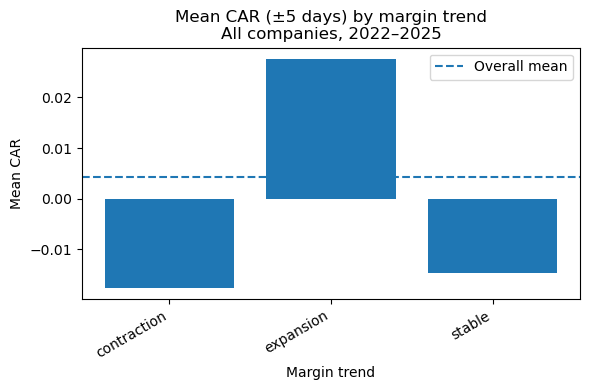

In [46]:
# Plot aggregate margin trend chart
plt.figure(figsize=(6, 4))
plt.bar(
    summary_margin_all[metric_col].astype(str),
    summary_margin_all["mean_car"]
)
plt.axhline(
    baseline_all,
    linestyle="--",
    label="Overall mean"
)

plt.title(
    "Mean CAR (±5 days) by margin trend\nAll companies, 2022–2025"
)
plt.ylabel("Mean CAR")
plt.xlabel("Margin trend")
plt.xticks(rotation=30, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

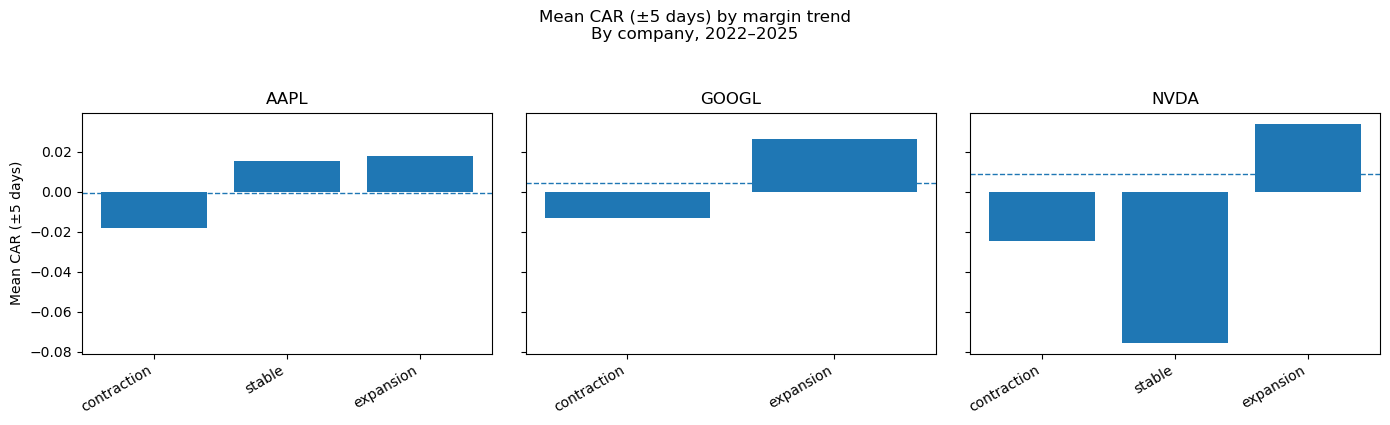

In [48]:
# Break out by firm
tickers = sorted(df_margin["symbol"].unique())
cat_order = ["contraction", "stable", "expansion"]

fig, axes = plt.subplots(1, len(tickers), figsize=(14, 4), sharey=True)
if len(tickers) == 1:
    axes = [axes]

for ax, ticker in zip(axes, tickers):
    df_t = df_margin[df_margin["symbol"] == ticker]

    summary = (
        df_t
        .groupby(metric_col)[car_col]
        .agg(mean_car="mean", n_events="size")
        .reset_index()
    )

    summary[metric_col] = pd.Categorical(
        summary[metric_col],
        categories=cat_order,
        ordered=True
    )
    summary = summary.sort_values(metric_col)

    x = range(len(summary))
    baseline = df_t[car_col].mean()

    ax.bar(x, summary["mean_car"])
    ax.axhline(baseline, linestyle="--", linewidth=1)

    ax.set_xticks(x)
    ax.set_xticklabels(summary[metric_col], rotation=30, ha="right")
    ax.set_title(ticker)

axes[0].set_ylabel("Mean CAR (±5 days)")
fig.suptitle(
    "Mean CAR (±5 days) by margin trend\nBy company, 2022–2025",
    y=1.05
)
plt.tight_layout()
plt.savefig("margin_trend_by_firm.png", dpi=300, bbox_inches="tight")
plt.show()

### Observations
Margin trends show a clear relationship with short-term post-earnings returns, particularly in the current tightening environment, where margin expansion is consistently rewarded and contraction is penalised. The strength of this effect varies by firm, with especially strong responses for NVIDIA and clearer signals for Google than for Apple, reinforcing the need for ticker-specific analysis rather than a uniform earnings strategy.